# Exploratory Data Analysis (EDA)




**Author:** John Doe

**Goal:** perform exploratory data analysis (EDA),

**Notebook standards:** PEP8-style code, modular cells, inline explanations, and reproducible plotting.

## Objectives

1. Understand the structure and quality of the dataset.
2. Identify missing values, outliers, and data inconsistencies.
3. Explore relationships between features and the target variable.
4. Prepare the dataset for modeling by cleaning and transforming it.

  This notebook is organized into sections: Imports → Utilities → Load Data → Data Overview → Cleaning → EDA → Feature Engineering → Summary.

###  Imports

In [2]:
# Standard library imports
import os
from typing import Tuple
import warnings
# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

# Constants
DATA_PATH = r"..\data\raw\premiums_young_with_gr.xlsx"  # update path if file is located elsewhere




### Utilities

In [3]:
def load_data(path:str) -> pd.DataFrame:
    '''
    Loads data from csv or excel file with safe checks

    Returns data frame
    '''
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found at: {path}. Please place the file in the working directory or update DATA_PATH.")
    if path.lower().endswith('.xlsx') or path.lower().endswith('.xls'):
        df = pd.read_excel(path)
    elif path.lower().endswith('csv'):
        df = pd.read_csv(path)
    else:
        raise ValueError('Unsupported file format. Provide .csv or .xlsx')
    return df

def overview(df: pd.DataFrame, n: int = 5) -> None:
    """Print quick dataset overview: shape, dtypes, head, and missing values."""
    print(f"Shape: {df.shape}\n")
    display(df.head(n))


def set_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names: lowercase, underscores, strip."""
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('-', '_')
    )
    return df




### Load Data

In [4]:
# Load the dataset (update DATA_PATH if necessary)
try:
    df = load_data(DATA_PATH)
    df = set_column_names(df)
    print('Data loaded Successfully.')
except Exception as exec:
    print('Data failed to load',exec)

if not df.empty:
    overview(df)


Data loaded Successfully.
Shape: (20096, 14)



,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


## Data quality checks

We'll inspect missing values,duplicates, extreme values, and column-level notes.

For each problematic column we'll add a proposed action (impute/transform/remove).

In [5]:
if df.empty:
    print('No data present — please load the file and re-run the cell.')
else:
    # Missing values
    print('Missing Values')
    display(df.isna().sum()) 

    # Duplicates
    dup_count = df.duplicated().sum()
    print(f"Duplicated count: {dup_count}")

    #summary statistics
    display(df.describe(include=[np.number]).T)

    # Cardinality for object columns (top categories)
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if object_cols:
        for col in object_cols:
            top = df[col].value_counts(dropna=False).head(10)
            print(f"\nColumn: {col} — unique: {df[col].nunique()}\nTop values:\n{top}\n")
    


Missing Values


age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

Duplicated count: 0


,count,mean,std,min,25%,50%,75%,max
age,20096.0,21.494029,2.294050,18.0,19.0,21.5,23.0,25.0
number_of_dependants,20096.0,0.718004,0.940767,-3.0,0.0,0.0,1.0,3.0
income_lakhs,20096.0,22.506519,23.418644,1.0,6.0,16.0,31.0,790.0
annual_premium_amount,20096.0,8141.941033,2749.609551,3501.0,6022.0,7939.0,9561.0,18186.0
genetical_risk,20096.0,2.503881,1.710115,0.0,1.0,3.0,4.0,5.0



Column: gender — unique: 2
Top values:
gender
Male      11058
Female     9038
Name: count, dtype: int64


Column: region — unique: 4
Top values:
region
Southeast    6972
Southwest    6123
Northwest    4044
Northeast    2957
Name: count, dtype: int64


Column: marital_status — unique: 2
Top values:
marital_status
Unmarried    18084
Married       2012
Name: count, dtype: int64


Column: bmi_category — unique: 4
Top values:
bmi_category
Normal         11605
Underweight     4471
Overweight      2743
Obesity         1277
Name: count, dtype: int64


Column: smoking_status — unique: 6
Top values:
smoking_status
No Smoking        13855
Regular            4491
Occasional         1738
Smoking=0             5
Does Not Smoke        3
Not Smoking           2
NaN                   2
Name: count, dtype: int64


Column: employment_status — unique: 3
Top values:
employment_status
Freelancer       10048
Salaried          7034
Self-Employed     3013
NaN                  1
Name: count, dtype: int64


Col

## Cleaning strategy (high level)

- Numerical columns: inspect distribution → impute with median or domain-specific cap.
- Categorical columns: fill missing with 'Unknown' or 'Missing' if appropriate, or create a flag column.
- Dates: parse and extract useful features (year, month, age from DOB).
- Outliers: cap using domain-informed thresholds or use percentile capping (1st/99th).

In [6]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """A sample cleaning pipeline."""
    df = df.copy()

    # Removing null values as they are less in number
    df.dropna(inplace=True)

    # Handling duplicated values
    df.drop_duplicates(inplace=True)

    # Handling negative values in number of dependent column
    df['number_of_dependants'] = abs(df['number_of_dependants']) 

    # smoking column
    df['smoking_status']=df['smoking_status'].apply(lambda row: 'No Smoking' if row not in ['Regular', 'Occasional'] else row )

    # handling the outliers for income_lakhs
    quantile_threshold = df.income_lakhs.quantile(0.999)
    df = df[df['income_lakhs']<=quantile_threshold]

    return df

# Apply cleaning
if not df.empty:
    df_clean = clean_dataframe(df)
    print('Cleaning applied — preview:')
    display(df_clean.head())
else:
    df_clean = df

Cleaning applied — preview:


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


### Distribution plots 


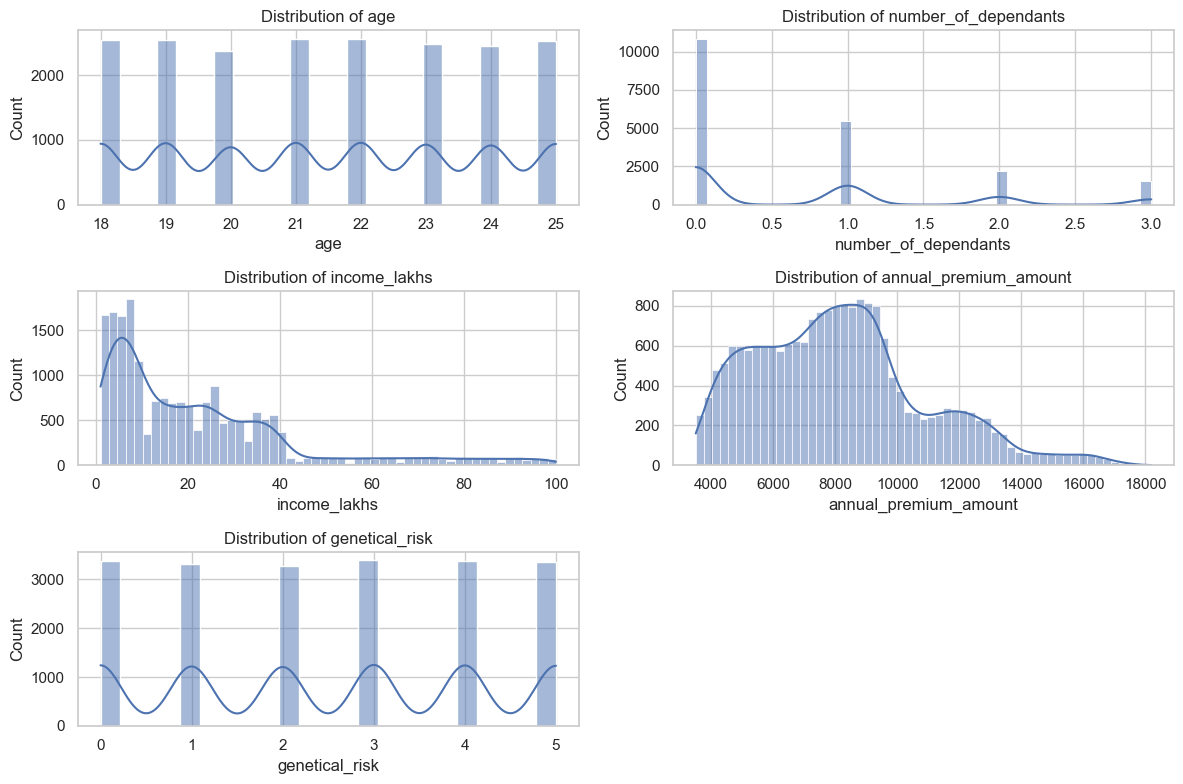

In [7]:
def plot_numerical_distribution(data: pd.DataFrame, columns: list):
    fig, axes = plt.subplots(len(columns) // 2 + len(columns) % 2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for idx, col in enumerate(columns):
        sns.histplot(data[col], ax=axes[idx], kde=True)
        axes[idx].set_title(f'Distribution of {col}')

    # Hide any unused subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


num_cols = df.select_dtypes(exclude='object').columns.tolist()
plot_numerical_distribution(df_clean, num_cols)

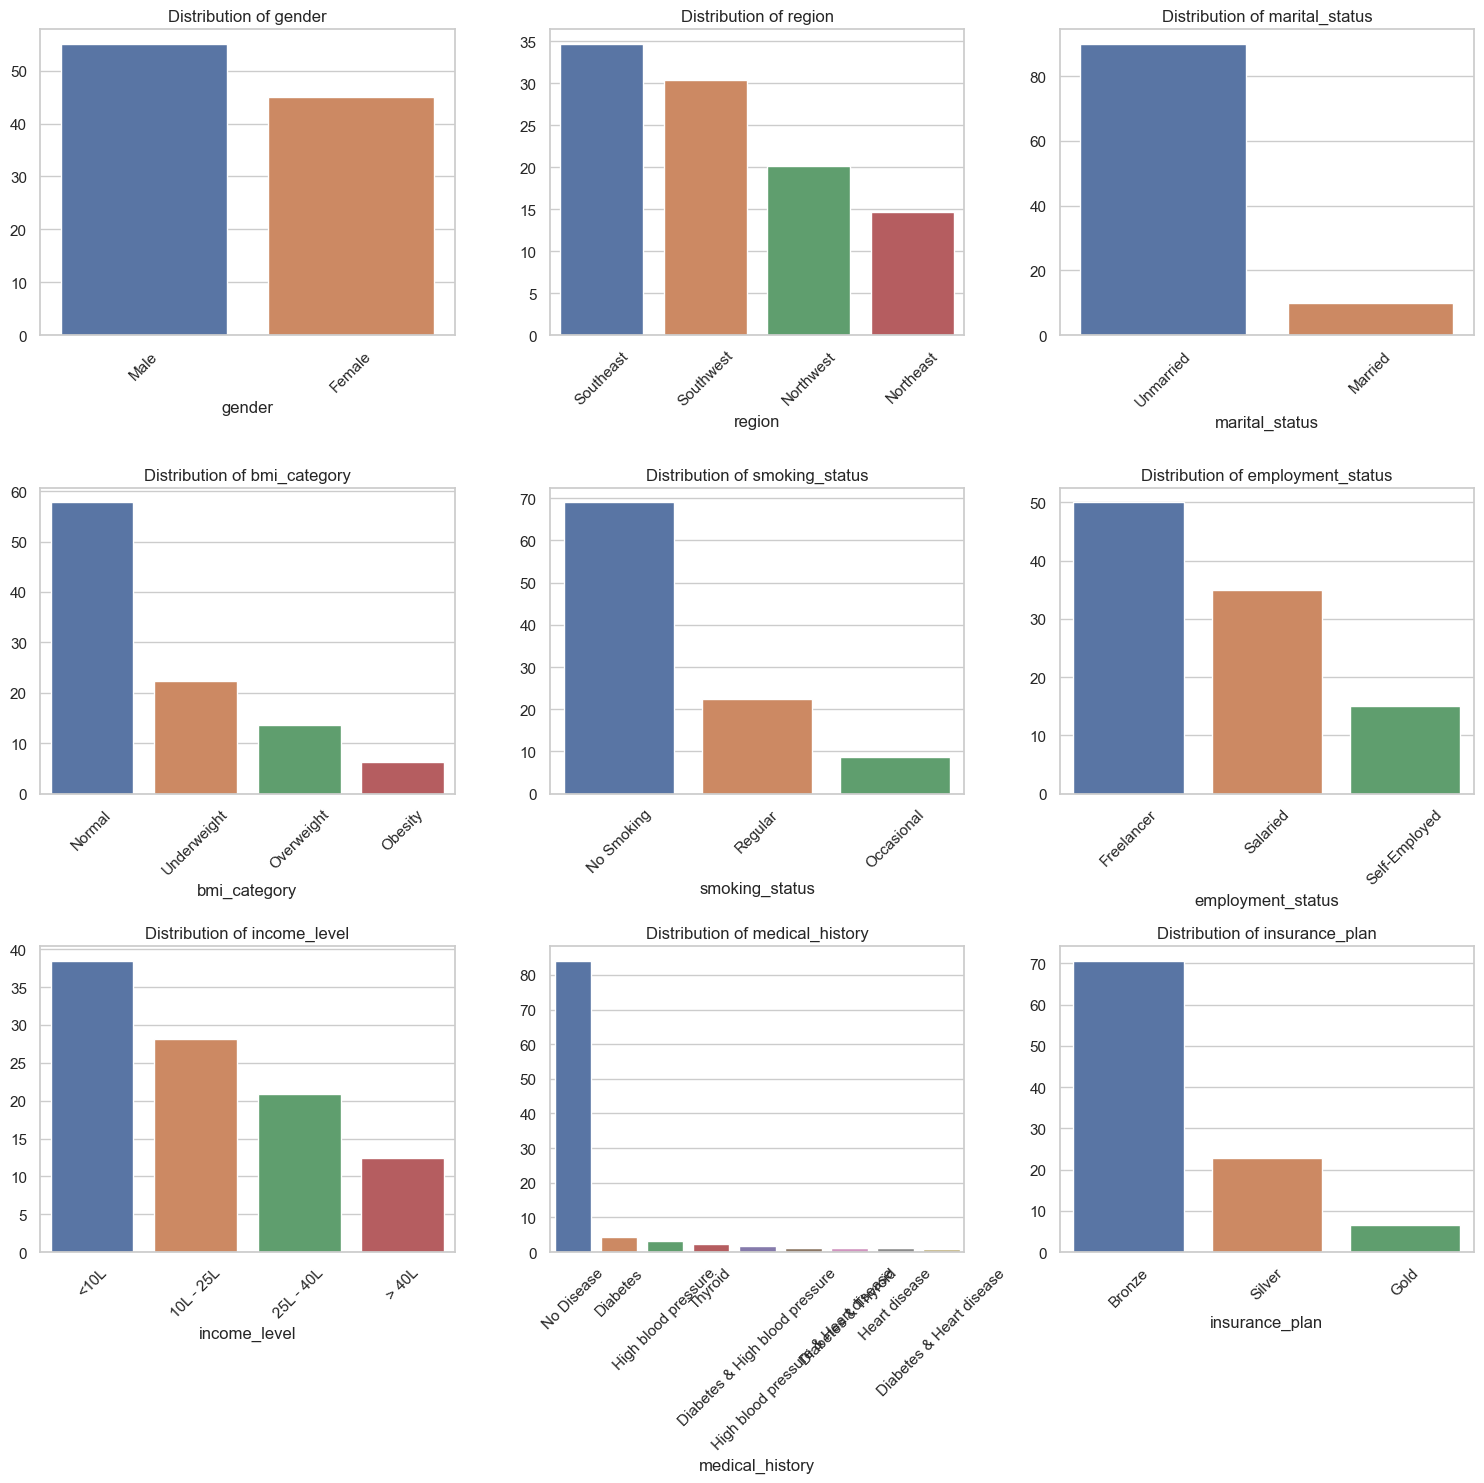

In [8]:
def plot_categorical_distribution(data: pd.DataFrame, columns: list):
    """Plot count plots for categorical columns."""
    n_col = 3
    n_row = (len(columns) // n_col)
    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 5*n_row))
    axes = axes.flatten()
    for idx, col in enumerate(columns):
        cat_count = data[col].value_counts(normalize=True)*100
        plot = sns.barplot(y=cat_count.values,x=cat_count.index,ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

cat_cols = df.select_dtypes('object').columns.tolist()
plot_categorical_distribution(df_clean, cat_cols)

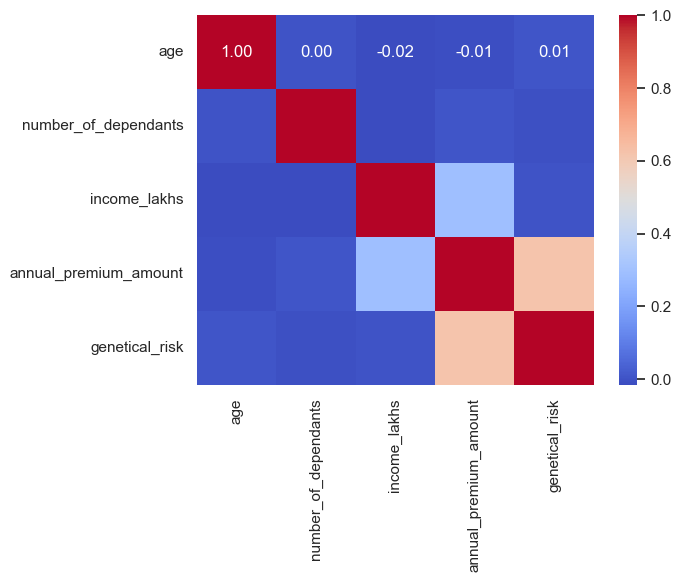

In [9]:
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f',cmap='coolwarm')
plt.show()

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    20086 non-null  int64 
 1   gender                 20086 non-null  object
 2   region                 20086 non-null  object
 3   marital_status         20086 non-null  object
 4   number_of_dependants   20086 non-null  int64 
 5   bmi_category           20086 non-null  object
 6   smoking_status         20086 non-null  object
 7   employment_status      20086 non-null  object
 8   income_level           20086 non-null  object
 9   income_lakhs           20086 non-null  int64 
 10  medical_history        20086 non-null  object
 11  insurance_plan         20086 non-null  object
 12  annual_premium_amount  20086 non-null  int64 
 13  genetical_risk         20086 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 2.3+ MB


In [13]:
OUT_PATH = r'..\data\processed\cleaned.xlsx'

if not df_clean.empty:
    df_clean.to_excel(OUT_PATH, index=False)
    print(f'Cleaned dataset exported to {OUT_PATH}')
else:
    print('No cleaned dataset to export.')

Cleaned dataset exported to ..\data\processed\cleaned.xlsx
